In [1]:
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix, make_scorer, precision_score
from sklearn import metrics
import os
import json
from werkzeug.utils import secure_filename
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2


### 1. Definir función de características:

In [2]:
# AÑADIR FUNCIÓN:
def sift(filename) -> np.array:
    img = cv2.imread(filename)

    # Transformar imagen de BGR a escala de grises
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Inicializar SIFT
    sift = cv2.SIFT_create()

    # Encontrar los puntos clave en la imagen
    _ , descriptors = sift.detectAndCompute(gray, mask=None)

    return descriptors

### 2. Definir métrica de distancia:

In [3]:
def sift_similarity_score(descriptors1, descriptors2, threshold=0.5):
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)

    good = []
    for m, n in matches:
        if m.distance < threshold * n.distance:
            good.append(m)

    # Calcula una puntuación de similitud en función de la cantidad de buenas coincidencias
    similarity_score = len(good) / min(len(descriptors1), len(descriptors2))

    return similarity_score

In [4]:
filename1 = 'static/0.jpg'
filename2 = 'static/10.jpg'

descr1 = sift(filename1)
descr2 = sift(filename2)

sift_similarity_score(descr1, descr2, 0.8)

0.02035928143712575

In [5]:
type(descr1)

numpy.ndarray

### 3. Calcular característica para todo dataset:

In [27]:
d = []

for i in range(0, 1000):
    if os.path.isfile(os.path.join('static', str(i) + '.jpg')):
        path = os.path.join('static', str(i) + '.jpg')
        hist = sift(path) ## CAMBIAR FUNCIÓN CARACTERÍSTICAS
        d.append(repr(hist.tolist()))

### 4. Generar df: 

INFO: hay 10 clases (las del vector 'clases'). las 100 primeras imags (0.jpg - 99.jpg) corresponden a la clase 'indigena', las 100 siguientes (100.jpg - 199.jpg) a la clase playa, ... y así.

In [28]:
df = pd.DataFrame(d)

clases = ['indigena', 'playa', 'monumento', 'autobus', 'dinosaurio', 'elefante', 'rosa', 'caballo', 'montaña', 'comida']
labels = []

for c in clases: 
    labels += [c]*100

df['class'] = labels

In [29]:
# comprobar que se ha añadido columna class:

df.head(5)

,0,class
0,"[[0.0, 0.0, 0.0, 0.0, 1.0, 11.0, 13.0, 0.0, 16...",indigena
1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 6.0,...",indigena
2,"[[7.0, 2.0, 2.0, 2.0, 155.0, 109.0, 45.0, 14.0...",indigena
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",indigena
4,"[[15.0, 2.0, 1.0, 7.0, 11.0, 35.0, 19.0, 15.0,...",indigena


### 4. Evaluar:

In [15]:
from distancia import sift_similarity_score

In [58]:
def eval_class(a, b):

    prec_media = 0
    for i in range(a, b):
        filename1 = 'static/'+str(i)+'.jpg'
        query_descriptors = sift(filename1)
        imgs_similares = []
        for k in range(0,1000):
            filename2 = 'static/'+str(k)+'.jpg'
            img_descriptors = sift(filename2)
            similarity_score = sift_similarity_score(query_descriptors, img_descriptors, 0.8)
            imgs_similares.append((k, similarity_score))
        imgs_similares_ordenada = sorted(imgs_similares, key=lambda x: x[1], reverse=True)

        prec_ej = 0
        for j in range(0,10):
            if imgs_similares_ordenada[j][0] in range(a, b):
                prec_ej += 1
        prec_media += prec_ej/10

    t = prec_media/100

In [59]:
prec_indigena = eval_class(0, 100)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [ ]:
prec_playa = eval_class(100, 200)

In [ ]:
prec_monumento = eval_class(200, 300)

In [ ]:
prec_autobus = eval_class(300, 400)

In [ ]:
prec_dinosaurio = eval_class(400, 500)

In [ ]:
clases = ['indigena', 'playa', 'monumento', 'autobus', 'dinosaurio', 'elefante', 'rosa', 'caballo', 'montaña', 'comida']
d = {}
t = 0
for c in clases: 
        df2 = df[df['class']==c]
        prec_media = 0
        for i in df2.index:
                prec_ej = 0
                query_descriptors = np.array(json.loads(df.loc[i][0]))
                print(len(query_descriptors))
                imgs_similares = []
                for k in range(len(df)):
                        img_descriptors = np.array(json.loads(df.loc[k][0]))
                        print(len(img_descriptors))
                        similarity_score = sift_similarity_score(img_descriptors, query_descriptors, 0.5)
                        imgs_similares.append((k, similarity_score))
                imgs_similares_ordenada = sorted(imgs_similares, key=lambda x: x[1], reverse=True)
                for j in imgs_similares_ordenada[:10]: 
                        if c == df.iloc[j]['class']:
                                prec_ej += 1
                prec_media += prec_ej/10
        t += prec_media/100
        d[c] = prec_media/100

t/len(clases)

### 5. Visualizar resultados para una imagen de entrada

In [6]:
def plot_c(filename):
    h = sift(filename) ## CAMBIAR FUNCIÓN CARACTERÍSTICAS
    imgs_similares = []
    for k in range(0,1000):
        filename2 = 'static/'+str(k)+'.jpg'
        img_descriptors = sift(filename2)
        similarity_score = sift_similarity_score(h, img_descriptors, 0.8)
        imgs_similares.append((k, similarity_score))
    imgs_similares_ordenada = sorted(imgs_similares, key=lambda x: x[1], reverse=True)[:10]

    plt.figure(figsize=(20, 10))
    i = 1
    for v, _ in imgs_similares_ordenada: 
        path = os.path.join('static', str(v) + '.jpg')
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1,10,i)
        plt.imshow(img)
        i += 1

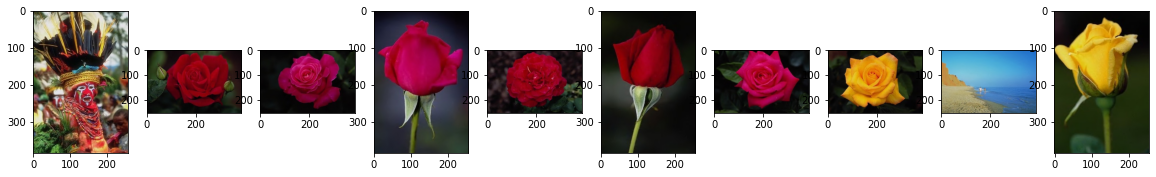

In [8]:
filename = 'static/80.jpg' ## CAMBIAR NOMBRE IMG (o no)
plot_c(filename)


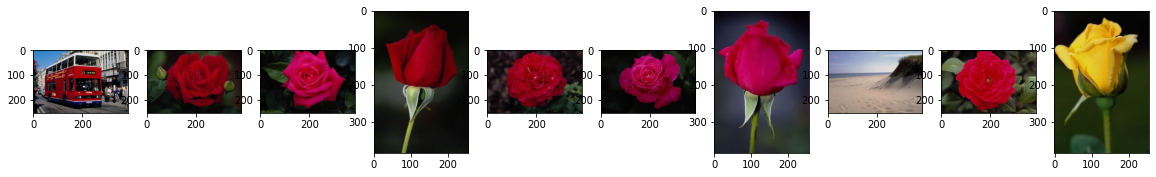

In [9]:
filename = 'static/302.jpg' ## CAMBIAR NOMBRE IMG (o no)
plot_c(filename)